In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astroML.stats import binned_statistic_2d

from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

## Figure that shows key model predictions

In [2]:
test_dir = '../model/'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_1.yaml')

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)


# The results of the final sampling process
result_file = os.path.join(test_dir, 'asap_test_1_sample.npz')

# Load in the final sampling results
(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = io.load_npz_results(result_file)

# Predict the stellar mass in inner and outer apertures
logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
    um_data['um_mock'], mod_result_best, min_logms=10.5,
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=cfg['um']['pivot_logmh'])

# Predict the SMFs and DeltaSigma profiles
um_smf_tot, um_smf_inn, um_dsigma = make_model_predictions(
    mod_result_best, cfg, obs_data, um_data)

# Check the likelihood for SMF and DeltaSigma profiles
lnlike_smf, lnlike_dsigma = ln_likelihood(
    mod_result_best, cfg, obs_data, um_data, sep_return=True)

# The useful part of the mock catalog
um_mock_use = um_data['um_mock'][mask_use]

print("\n# Best parameters: ", mod_result_best)
print("# ln(Likelihood) for SMFs   : %8.4f" % lnlike_smf)
print("# ln(Likelihood) for DSigma : %8.4f" % lnlike_dsigma)

# Running model: asap_test_1
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   180 x  3 steps of burn-in
#    Use   256 walkers with        kde moves for   400 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total stella

### Figure that shows the aperture mass plane and the definitions of the mass bins

/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


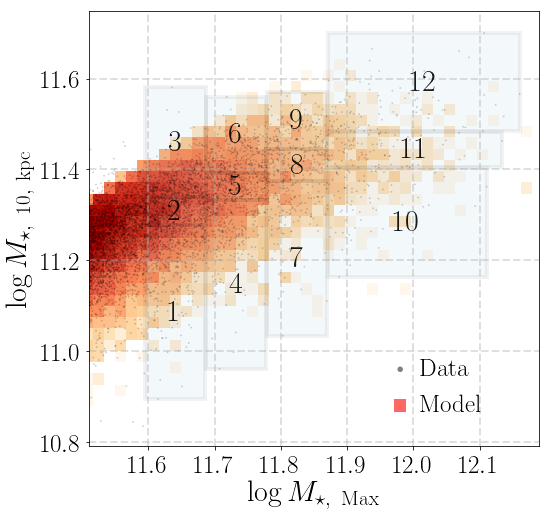

In [4]:
fig_1 = plt.figure(figsize=(7.5, 7))
fig_1.subplots_adjust(left=0.16, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# Mmax - M10 scatter plot
mask_mod = ((logms_tot >= 11.45) & (logms_tot <= 12.20) & 
            (logms_inn >= 10.65) & (logms_inn <= 11.70))

x_arr = logms_tot[mask_mod]
y_arr = logms_inn[mask_mod]
z_arr = um_mock_use['logmh_vir'][mask_mod]

z_stats, x_edges, y_edges = binned_statistic_2d(
    x_arr, y_arr, z_arr, 'count', bins=(45, 40))

z_img = z_stats.T
z_img[z_img <= 1] = 0

# Density plot for the model predictions
HM = ax1.imshow(np.log10(z_img), origin='lower',
                extent=[x_edges[0], x_edges[-1],
                        y_edges[0], y_edges[-1]],
                aspect='auto', interpolation='nearest',
                cmap='OrRd', label=r'$\mathrm{Model}$')

# Show the individual galaxies
ax1.scatter(obs_data['mtot'], obs_data['minn'], s=3, alpha=0.2, 
            facecolor='k', edgecolor='none', label=r'$\mathrm{Data}$')

# Create a manual legend
ax1.scatter(11.98, 10.96, marker='o', facecolor='k', s=30, edgecolor='None', alpha=0.5)
ax1.text(12.01, 10.96, r'$\mathrm{Data}$', fontsize=25, 
         horizontalalignment='left', verticalalignment='center')

ax1.scatter(11.98, 10.88, marker='s', facecolor='r', s=150, edgecolor='None', alpha=0.6)
ax1.text(12.01, 10.88, r'$\mathrm{Model}$', fontsize=25, 
         horizontalalignment='left', verticalalignment='center')

_ = ax1.set_xlim(11.51, 12.19)
_ = ax1.set_ylim(10.79, 11.75)

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=30)


for ii in np.arange(12):
    obs_prof = obs_data['wl_dsigma'][ii]
    ax1.add_patch(
        patches.Rectangle(
            (obs_prof['min_logm1'], obs_prof['min_logm2']),
            (obs_prof['max_logm1'] - obs_prof['min_logm1']),
            (obs_prof['max_logm2'] - obs_prof['min_logm2']), 
            alpha=0.05, edgecolor='k', linewidth=4))
    ax1.text((obs_prof['max_logm1'] + obs_prof['min_logm1']) / 2.0, 
             (obs_prof['max_logm2'] + obs_prof['min_logm2']) / 2.0,
             r"$%d$" % (ii + 1), 
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=30, color='k', alpha=0.9)

### Figure to compare the SMFs

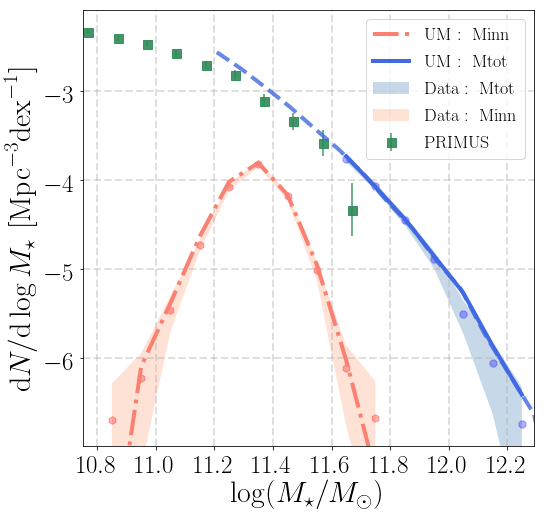

In [9]:
fig_2 = plt.figure(figsize=(7.5, 7))
fig_2.subplots_adjust(left=0.16, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)

ax1 = fig_2.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# These are the SMFs and stellar mass data
obs_smf_tot = obs_data['smf_tot']
obs_smf_inn = obs_data['smf_inn']
obs_logms_tot = obs_data['mtot']
obs_logms_inn = obs_data['minn']
obs_smf_full = obs_data['smf_full']


# This is the model SMF with broader mass range
um_smf_tot_all = smf.get_smf_bootstrap(logms_tot, cfg['um']['volume'], 18, 11.0, 12.5, n_boots=1)

# Show the PRIMUS SMF
ax1.errorbar(obs_smf_full['logm_mean'][6:] + 0.17,
             np.log10(obs_smf_full['smf'][6:]),
             (np.log10(obs_smf_full['smf_upp'][6:]) - np.log10(obs_smf_full['smf'][6:])),
             fmt='o', color='seagreen', ecolor='seagreen', alpha=0.9, marker='s', markersize=9,
             label=r'$\mathrm{PRIMUS}$', zorder=0)

# Show the HSC SMFs
ax1.fill_between(obs_smf_tot['logm_mean'], np.log10(obs_smf_tot['smf_low']), np.log10(obs_smf_tot['smf_upp']),
                 facecolor='steelblue', edgecolor='none', interpolate=True, alpha=0.3,
                 label=r'$\mathrm{Data:\ Mtot}$')

ax1.fill_between(obs_smf_inn['logm_mean'], np.log10(obs_smf_inn['smf_low']), np.log10(obs_smf_inn['smf_upp']),
                 facecolor='lightsalmon', edgecolor='none', interpolate=True, alpha=0.3,
                 label=r'$\mathrm{Data:\ Minn}$')

ax1.scatter(obs_smf_inn['logm_mean'], np.log10(obs_smf_inn['smf']),
            marker='h', c='r', s=60, label='__no_label__', alpha=0.3)

ax1.scatter(obs_smf_tot['logm_mean'], np.log10(obs_smf_tot['smf']),
            marker='8', c='b', s=60, label='__no_label__', alpha=0.3)


# Predicted SMF
ax1.plot(obs_smf_inn['logm_mean'], np.log10(um_smf_inn),
         linewidth=4, linestyle='-.', c='salmon', alpha=1.0, label=r'$\mathrm{UM:\ Minn}$')

ax1.plot(um_smf_tot_all['logm_mean'][2:], np.log10(um_smf_tot_all['smf'][2:]),
         linewidth=4, linestyle='--', c='royalblue', alpha=0.8, label='__no_label__')

ax1.plot(obs_smf_tot['logm_mean'], np.log10(um_smf_tot),
         linewidth=4, linestyle='-', c='royalblue', alpha=1.0, label=r'$\mathrm{UM:\ Mtot}$')


ax1.legend(fontsize=18, loc='upper right')

ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$', fontsize=30)
ax1.set_ylabel((r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ $'
                r'$[{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'), size=30)

_ = ax1.set_xlim(10.75, 12.29)
_ = ax1.set_ylim(-6.99, -2.09)

### Figure that shows the predicted DeltaSigma profiles 

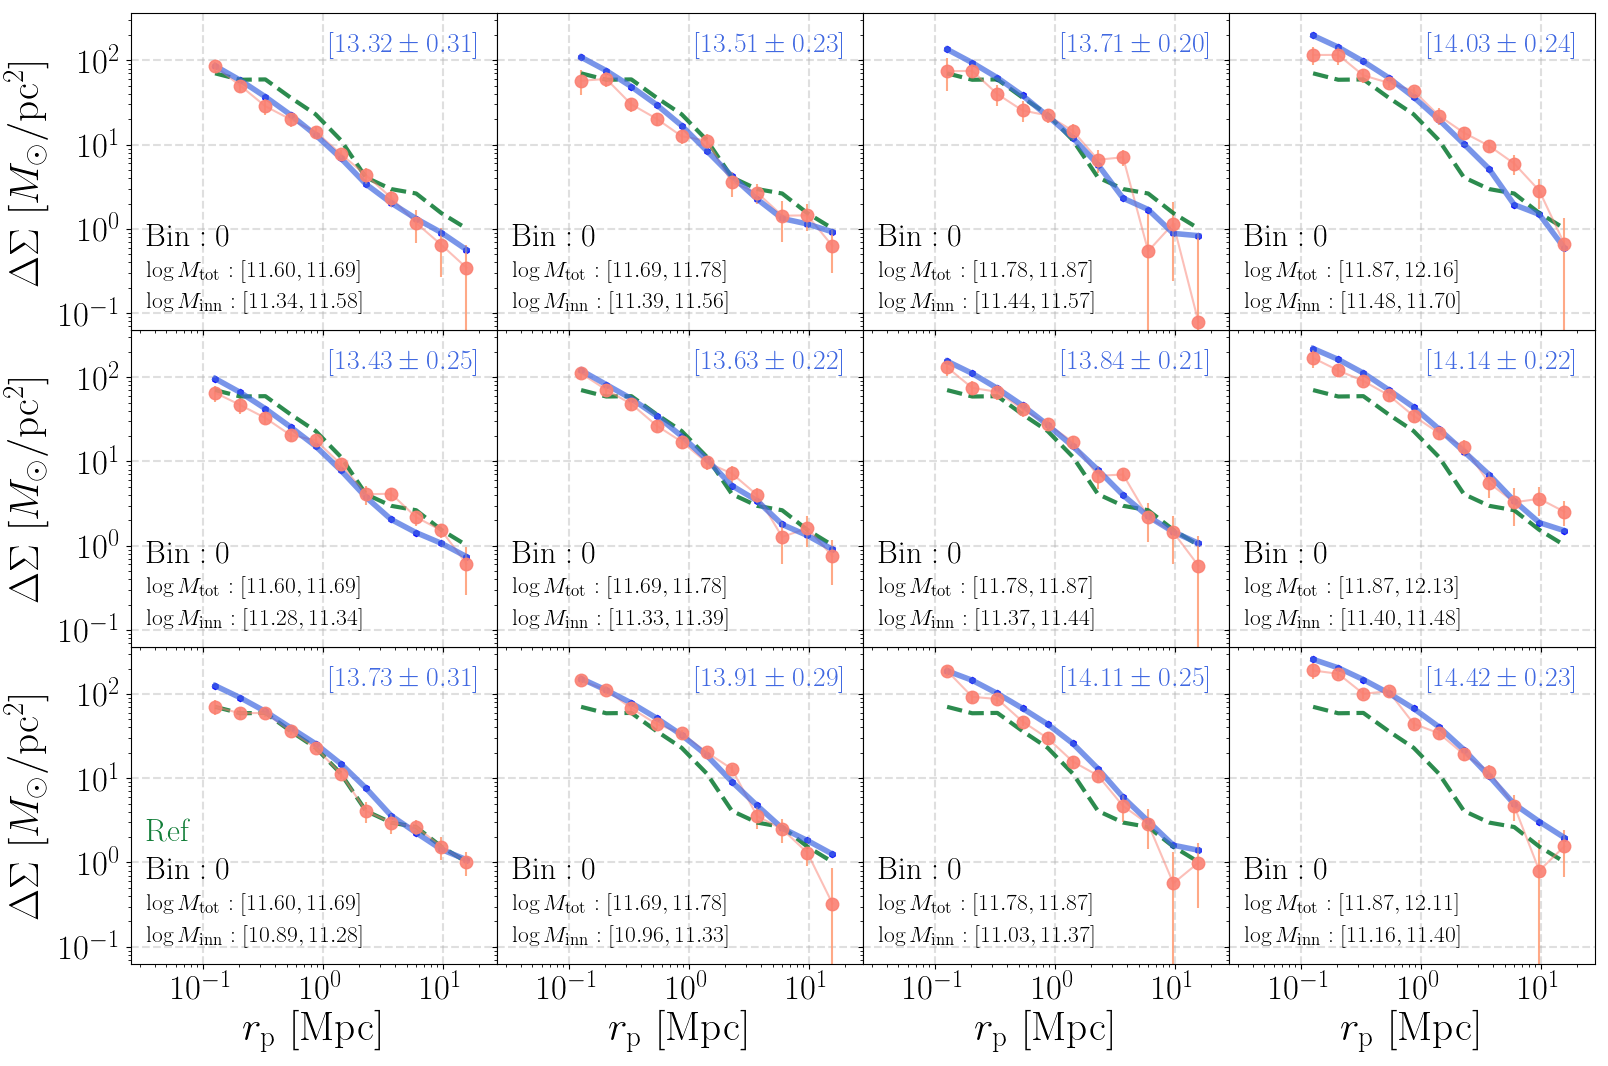

In [3]:
um_mhalo_tuple = predict_mhalo(
    obs_data['wl_dsigma'], um_data['um_mock'][mask_use], logms_tot, logms_inn)

mod_dsig = plotting.plot_dsigma_profiles(
    obs_data['wl_dsigma'], um_dsigma, um_mhalo=um_mhalo_tuple, reference=0)

### Save the figures

In [11]:
fig_1.savefig('fig/fig4_a_plane.pdf', dpi=120)

fig_2.savefig('fig/fig4_b_smsf.pdf', dpi=120)

mod_dsig.savefig('fig/fig4_c_dsigma.pdf', dpi=120)